In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
import os, pandas as pd
# Add asset from file system
dataset = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/appl.csv')
dataset.head()




,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-05-26,45.531250,45.71875,45.312500,45.718750,35.550995,74800
1,2000-05-30,46.375000,47.40625,46.375000,47.406250,36.863197,57600
2,2000-05-31,47.562500,48.18750,47.562500,47.578125,36.996853,36000
3,2000-06-01,48.554688,48.65625,48.554688,48.656250,37.835213,7000
4,2000-06-02,50.859375,51.18750,50.859375,51.187500,39.803505,29400


In [32]:
stocks = dataset.loc[(dataset['date']>='2017-01-01') & (dataset['date']<='2017-12-31')]
#stocks=dataset

In [33]:
# getting the list of all companies 
companies = stocks.ticker.unique()
companies.sort()

In [100]:
from sklearn.preprocessing import MinMaxScaler

# we are creating 2 arrays, x_train and y_train.¶
# x_train stores the values of adjusted closing prices of past 60 days
# y_train stores the values of adjusted closing prices of the present day

period = 15
x_train = []
y_train = []
companies_sc = []

for company in companies:
    
    sc = MinMaxScaler()
    stock = stocks.loc[stocks['ticker'] == company]
    
    # creating an array with adjusted closing prices
    training_set = stock[['adj_close']].values
    
    # normalizing the values
    training_set_scaled = sc.fit_transform(training_set)
    training_set_scaled.shape
    
    # In the below cell, we are appendding data to x_train and y_train.¶
    
    length = len(training_set)
    for i in range(period, length):
        x_train.append(training_set_scaled[i-period:i, 0])
        y_train.append(training_set_scaled[i, 0])
        
    companies_sc.append(sc)
        
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train.shape

(236, 15)

In [101]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(236, 15, 1)

In [102]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()

model.add(LSTM(units = 92, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

# model.add(LSTM(units = 92, return_sequences = True))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 92, return_sequences = True))
# model.add(Dropout(0.2))

model.add(LSTM(units = 92, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [103]:
train = model.fit(x_train, y_train, verbose=2, epochs = 100, batch_size = 3000, validation_split=0.33)

Train on 158 samples, validate on 78 samples
Epoch 1/100
 - 2s - loss: 0.2374 - val_loss: 0.4422
Epoch 2/100
 - 0s - loss: 0.1738 - val_loss: 0.3074
Epoch 3/100
 - 0s - loss: 0.1191 - val_loss: 0.1839
Epoch 4/100
 - 0s - loss: 0.0692 - val_loss: 0.0790
Epoch 5/100
 - 0s - loss: 0.0287 - val_loss: 0.0131
Epoch 6/100
 - 0s - loss: 0.0056 - val_loss: 0.0197
Epoch 7/100
 - 0s - loss: 0.0157 - val_loss: 0.0638
Epoch 8/100
 - 0s - loss: 0.0400 - val_loss: 0.0605
Epoch 9/100
 - 0s - loss: 0.0385 - val_loss: 0.0312
Epoch 10/100
 - 0s - loss: 0.0246 - val_loss: 0.0094
Epoch 11/100
 - 0s - loss: 0.0094 - val_loss: 0.0058
Epoch 12/100
 - 0s - loss: 0.0050 - val_loss: 0.0152
Epoch 13/100
 - 0s - loss: 0.0055 - val_loss: 0.0294
Epoch 14/100
 - 0s - loss: 0.0092 - val_loss: 0.0422
Epoch 15/100
 - 0s - loss: 0.0131 - val_loss: 0.0505
Epoch 16/100
 - 0s - loss: 0.0156 - val_loss: 0.0533
Epoch 17/100
 - 0s - loss: 0.0172 - val_loss: 0.0508
Epoch 18/100
 - 0s - loss: 0.0159 - val_loss: 0.0443
Epoch 19/1

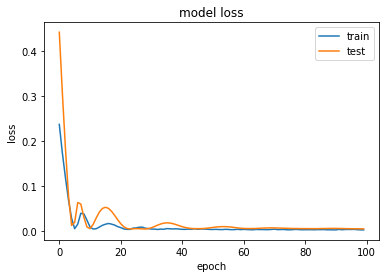

In [104]:
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [105]:
test_set = dataset.loc[(dataset['ticker'] == 'AAPL') & (dataset['date']>='2018-01-01')]  
test_set = test_set.loc[:, test_set.columns == 'adj_close']

In [106]:
y_test = test_set.iloc[period:, 0:].values

In [107]:
sc = companies_sc[np.where(companies=="AAPL")[0][0]]
# storing all values in a variable for generating an input array for our model 
adj_closing_price = test_set.iloc[:, 0:].values
adj_closing_price_scaled = sc.transform(adj_closing_price)

In [108]:
# the model will predict the values on x_test
x_test = [] 
length = len(test_set)

for i in range(period, length):
    x_test.append(adj_closing_price_scaled[i-period:i, 0])
    
x_test = np.array(x_test)

In [109]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(149, 15, 1)

In [110]:
# predicting the stock price values
y_pred = model.predict(x_test)
predicted_price = sc.inverse_transform(y_pred)

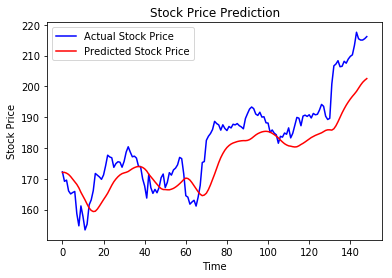

In [111]:
# plotting the results
plt.plot(y_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'red', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()